## Keras implementation of https://junyanz.github.io/CycleGAN/

In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # can choose theano, tensorflow, cntk
os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_run,dnn.library_path=/usr/lib'
#os.environ['THEANO_FLAGS']='floatX=float32,device=cuda,optimizer=fast_compile,dnn.library_path=/usr/lib'

In [2]:
import keras.backend as K
if os.environ['KERAS_BACKEND'] =='theano':
    channel_axis=1
    K.set_image_data_format('channels_first')
    channel_first = True
else:
    K.set_image_data_format('channels_last')
    channel_axis=-1
    channel_first = False

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate, ZeroPadding2D, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal

In [4]:
# Weights initializations
# bias are initailized as 0
def __conv_init(a):
    print("conv_init", a)
    k = RandomNormal(0, 0.02)(a) # for convolution kernel
    k.conv_weight = True    
    return k
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


In [5]:
# HACK speed up theano
if K._BACKEND == 'theano':
    import keras.backend.theano_backend as theano_backend
    def _preprocess_conv2d_kernel(kernel, data_format):
        #return kernel
        if hasattr(kernel, "original"):
            print("use original")
            return kernel.original
        elif hasattr(kernel, '_keras_shape'):
            s = kernel._keras_shape
            print("use reshape",s)
            kernel = kernel.reshape((s[3], s[2],s[0], s[1]))
        else:
            kernel = kernel.dimshuffle((3, 2, 0, 1))
        return kernel
    theano_backend._preprocess_conv2d_kernel = _preprocess_conv2d_kernel

In [6]:
# Basic discriminator
def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=channel_axis, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in, ndf, input_size = (None, None), max_layers=3, use_sigmoid=True):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    
    if channel_first:
        input_a =  Input(shape=(nc_in, *input_size))
    else:
        input_a = Input(shape=(*input_size, nc_in))
    _ = input_a
    _ = conv2d(ndf, kernel_size=4, strides=2, padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=4, strides=2, padding="same", 
                   use_bias=False, name = 'pyramid.{0}'.format(layer)             
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(out_feat, kernel_size=4,  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D(1)(_)
    _ = conv2d(1, kernel_size=4, name = 'final'.format(out_feat, 1)) (_)    
    
    _ = Flatten(name = 'flatten') (_)
    _ = Dense(1, name = 'final_dense', activation = "sigmoid" if use_sigmoid else None) (_)
    
    return Model(inputs=[input_a], outputs=_)

In [7]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [8]:
def UNET_G_SM(isize, nc_in=3, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, s, s))
    else:
        _ = inputs = Input(shape=(s, s, nc_in))        
    _ = block(_, isize, nc_in, False, nf_out=ngf, nf_next=ngf)
    _ = Activation('relu')(_)
    _ = Conv2DTranspose(ngf, kernel_size=(13, 4), strides=(1, 2),
                            use_bias=True,
                            kernel_initializer = conv_init,
                            name = 'convt.fin')(_)
    _ = Cropping2D((0, 1))(_)
    
    _ = Activation("relu")(_)
    _ = Conv2DTranspose(ngf//2, kernel_size=4, strides=2,
                        use_bias=True,
                        kernel_initializer = conv_init,          
                        name = 'convt.finfin')(_)        
    _ = Cropping2D(1)(_)
    _ = Activation('relu')(_)
    _ = Conv2DTranspose(nc_out, kernel_size=(3, 4), strides=(1, 2),
                        use_bias=True,
                        kernel_initializer = conv_init,          
                        name = 'convt.finfinfin')(_)        
    _ = Cropping2D(1)(_)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [9]:
def UNET_G_MS(isize, nc_in=1, nc_out=3, ngf=64, fixed_input_size=True):    
    max_nf = 8*ngf    
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=4, strides=2, use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = 'conv_{0}'.format(s)) (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=channel_axis)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=4, strides=2,
                            use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,
                            name = 'convt.{0}'.format(s))(x)        
        x = Cropping2D(1)(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    s = isize if fixed_input_size else None
    if channel_first:
        _ = inputs = Input(shape=(nc_in, *musicSize))
    else:
        _ = inputs = Input(shape=(*musicSize, nc_in))
    _ = conv2d(ngf, kernel_size=4, strides=(1, 2), use_bias=True,
                   padding="same", name = 'conv_superfirst') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    #_ = ZeroPadding2D(padding=(0, 1), data_format=None) (_)
    _ = conv2d(ngf*2, kernel_size=4, strides=2, use_bias=True,
                   padding="same", name = 'conv_first') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    _ = ZeroPadding2D(padding=(0, 1), data_format=None) (_)
    _ = conv2d(ngf*2, kernel_size=(13, 4), strides=(1,2), use_bias=True,
               padding="valid", name = 'conv_firstfirst') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    _ = block(_, isize, ngf*2, False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    return Model(inputs=inputs, outputs=[_])

In [10]:
nc_s = 3
nc_m = 1
ngf = 64
ndf = 128

spriteSize = (32, 32)
musicSize = (88, 256)
fs = 32
snap_to = 1 # snaps to every 1/4 of a second
snap_factor = 1 / snap_to
dur = 8.0
pitch_range = (21, 109)
binary_music = True

use_lsgan = True
λ = 10 if use_lsgan else 100
m_weight = 1

continue_training = False
batchSize = 2
lrD = 2e-4
lrG = 2e-4

assert((fs // snap_factor) * snap_factor == fs)

In [11]:
netGM = UNET_G_SM(32, nc_s, nc_m, ngf) #netGA
netGM.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv_32 (Conv2D)                (None, 16, 16, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 16, 64)   0           conv_32[0][0]                    
__________________________________________________________________________________________________
conv_16 (Conv2D)                (None, 8, 8, 128)    131072      leaky_re_lu_1[0][0]              
__________________________________________________________________________________________________
batch_norm

In [12]:
netGS = UNET_G_MS(32, nc_m, nc_s, ngf) #netGB
netGS.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 88, 256, 1)   0                                            
__________________________________________________________________________________________________
conv_superfirst (Conv2D)        (None, 88, 128, 64)  1088        input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 88, 128, 64)  0           conv_superfirst[0][0]            
__________________________________________________________________________________________________
conv_first (Conv2D)             (None, 44, 64, 128)  131200      leaky_re_lu_5[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [13]:
netDM = BASIC_D(nc_m, ndf, input_size = musicSize, use_sigmoid = not use_lsgan) # netDA
netDS = BASIC_D(nc_s, ndf, input_size = spriteSize, use_sigmoid = not use_lsgan) # netDB
netDM.summary()
netDS.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 88, 256, 1)        0         
_________________________________________________________________
First (Conv2D)               (None, 44, 128, 128)      2176      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 44, 128, 128)      0         
_________________________________________________________________
pyramid.1 (Conv2D)           (None, 22, 64, 256)       524288    
_________________________________________________________________
batch_normalization_15 (Batc (None, 22, 64, 256)       1024      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 22, 64, 256)       0         
_________________________________________________________________
pyramid.2 (Conv2D)           (None, 11, 32, 512)       2097152   
__________

In [14]:
from keras.optimizers import RMSprop, SGD, Adam

In [15]:
if use_lsgan:
    loss_fn = lambda output, target : K.mean(K.abs(K.square(output-target)))
else:
    loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

def cycle_variables(netG1, netG2):
    real_input = netG1.inputs[0]
    fake_output = netG1.outputs[0]
    rec_input = netG2([fake_output])
    fn_generate = K.function([real_input], [fake_output, rec_input])
    return real_input, fake_output, rec_input, fn_generate

real_M, fake_S, rec_M, cycleM_generate = cycle_variables(netGS, netGM)
real_S, fake_M, rec_S, cycleS_generate = cycle_variables(netGM, netGS)

In [16]:
def D_loss(netD, real, fake, rec):
    output_real = netD([real])
    output_fake = netD([fake])
    loss_D_real = loss_fn(output_real, K.ones_like(output_real))
    loss_D_fake = loss_fn(output_fake, K.zeros_like(output_fake))
    loss_G = loss_fn(output_fake, K.ones_like(output_fake))
    loss_D = loss_D_real+loss_D_fake
    loss_cyc = K.mean(K.abs(rec-real))
    return loss_D, loss_G, loss_cyc

loss_DM, loss_GM, loss_cycS = D_loss(netDM, real_M, fake_M, rec_M)
loss_DS, loss_GS, loss_cycM = D_loss(netDS, real_S, fake_S, rec_S)
loss_cyc = loss_cycM+loss_cycS

In [17]:
loss_G = loss_GM+loss_GS+λ*loss_cyc
loss_D = loss_DM+loss_DS

weightsD = netDM.trainable_weights + netDS.trainable_weights
weightsG = netGM.trainable_weights + netGS.trainable_weights

training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(weightsD,[],loss_D)
netD_train = K.function([real_M, real_S],[m_weight * loss_DM/2, loss_DS/2], training_updates)
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(weightsG,[], loss_G)
netG_train = K.function([real_M, real_S], [loss_GM, loss_GS, loss_cyc], training_updates)

In [18]:
!pip install pretty_midi
import pretty_midi

def prepare_midi(pm, fs = 16, duration = 30.0, pitchrange = (0, 128)):
    """ 
    Takes a given midi file name and returns a PrettyMIDI object and its piano roll. 

    Extended description of function. 

    Parameters: 
    name (str): Name of midi file
    fs (int): Samples per sec
    duration (float): duration of time to keep 
    pitchrange (tuple[int]): tuple of starting pitch and ending pitch. 0 to 127 possible

    Returns: 
    (PrettyMIDI, numpyArray): prettymidi object and cropped piano roll array

    """ 

    pmroll = pm.get_piano_roll(fs)[pitchrange[0] : pitchrange[1]]
    if duration > 0:
        pmroll = pmroll[:, 0 : int(duration * fs)]
    return pmroll

def to_midi(pr, fs = 8, pitchrange = (0, 128), force_velocity = False):
    pm = pretty_midi.PrettyMIDI()
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program = piano_program)
    
    pitch_start = pitchrange[0]
    for p in range(len(pr)):
        start = False
        startTime = 0.0
        v = 0
        for t in range(len(pr[p])):
            if not start and int(pr[p][t]) > 0:
                start = True
                v = int(pr[p][t])
                startTime = t / fs
            elif start and int(pr[p][t]) != v:
                endTime = t / fs
                vel = v
                if force_velocity:
                    vel = 125
                _ = pretty_midi.Note(velocity = vel, 
                                    pitch = pitch_start + p, start = startTime, end = endTime)
                piano.notes.append(_)
                if int(pr[p][t]) == 0:
                    start = False
                else:
                    startTime = endTime
                    v = int(pr[p][t])
    
    pm.instruments.append(piano)
    return pm


In [ ]:
def show_pitch_occur(midis):
    pitches = [0] * 128
    for fn in midis:        
        try:
            _ = pretty_midi.PrettyMIDI(fn)
            print(fn, "\n loading... loaded")
        except:
            print(fn, "\n loading... ERROR")
        roll = prepare_midi(_, fs = 8, duration = 0.0)
        for p in range(128):
            if len(set(roll[p])) > 1:
                pitches[p] += 1

    for p in range(128):
        print(p, pitches[p], sep=': ')

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import glob
from random import randint, shuffle

def load_data(file_pattern):
    return glob.glob(file_pattern, recursive = True)

def read_image(fn, imgSize, augment=False):
    im = Image.open(fn).convert("RGBA")
    im = im.resize(imgSize, Image.BILINEAR )
    img = np.array(im, dtype=np.float64)
    alphaLayer = img[:,:,3] / 255.0
    img[:,:,0] *= alphaLayer
    img[:,:,1] *= alphaLayer
    img[:,:,2] *= alphaLayer
    img = (img/255.0*2-1)[:,:,:3]
    if augment and randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    return img

def read_midi(fn, imgSize, fs, duration, prange, augment=False):
    try:
        _ = pretty_midi.PrettyMIDI(fn)
    except:
        return None
    roll = prepare_midi(_, fs, 0, prange)
    window = int(fs * duration)
    end = len(roll[0]) - int(5 * fs) - window
    if end < int(5 * fs):
        print(end, " not big enough (", fn, ")")
        return None
    start = np.random.randint(int(5 * fs), end)
    snap = fs // snap_factor
    start = int((start // snap) * snap)
    img = roll[:, start : start + window]
    if binary_music:
        img = np.clip(img, 0, 1)
    else:
        img = (img/128.0)
    if augment and randint(0,1):
        img=img[:,::-1]
    if channel_first:        
        img = np.moveaxis(img, 2, 0)
    if img.shape != imgSize:
        print("[ERROR] Created an invalid shaped piece of music data! Size: ", img.shape, " instead of ", imgSize)
    return img

data = "sprites2music"
train_S = load_data('trainingSet/sprites/**/*.png')
train_M = load_data('trainingSet/music/**/*.mid')

print("[Removing songs that are too short]")
to_remove = []
for m in train_M:
    if read_midi(m, musicSize, fs, dur, pitch_range) is None:
        to_remove.append(m)
for m in to_remove:
    train_M.remove(m)

assert len(train_M) and len(train_S)

shuffle(train_M)
shuffle(train_S)

print("Num midi files: ", len(train_M))
print("Num sprites: ", len(train_S))

[Removing songs that are too short]


C:\Users\mmille95\AppData\Local\conda\conda\envs\cycleGAN\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


-263  not big enough ( trainingSet/music\vgpiano\CastleVania_-_StageClear.mid )
-197  not big enough ( trainingSet/music\vgpiano\cchitcat.mid )
-288  not big enough ( trainingSet/music\vgpiano\command_melody_lozww_piano.mid )
-7  not big enough ( trainingSet/music\vgpiano\Creation_piano_.mid )
80  not big enough ( trainingSet/music\vgpiano\DKONG.mid )
36  not big enough ( trainingSet/music\vgpiano\dk_title.mid )
-324  not big enough ( trainingSet/music\vgpiano\GameOverPiano.mid )
-160  not big enough ( trainingSet/music\vgpiano\inverted_song_time_piano.mid )
-324  not big enough ( trainingSet/music\vgpiano\Mario_Dies_Super_Mario_World.mid )
-237  not big enough ( trainingSet/music\vgpiano\mmx5bossintropianoversion.mid )
-236  not big enough ( trainingSet/music\vgpiano\MP_Artifact_-_Piano_Only_-_By_DaDude.mid )
-234  not big enough ( trainingSet/music\vgpiano\MP_Item_Acquired_-_Piano_Only_-_By_DaDude.mid )
-77  not big enough ( trainingSet/music\vgpiano\Music_Box_Clock.mid )
159  not bi

402 trainingSet/music\vgpiano\TheSims_TheNeighborhood_Piano.mid


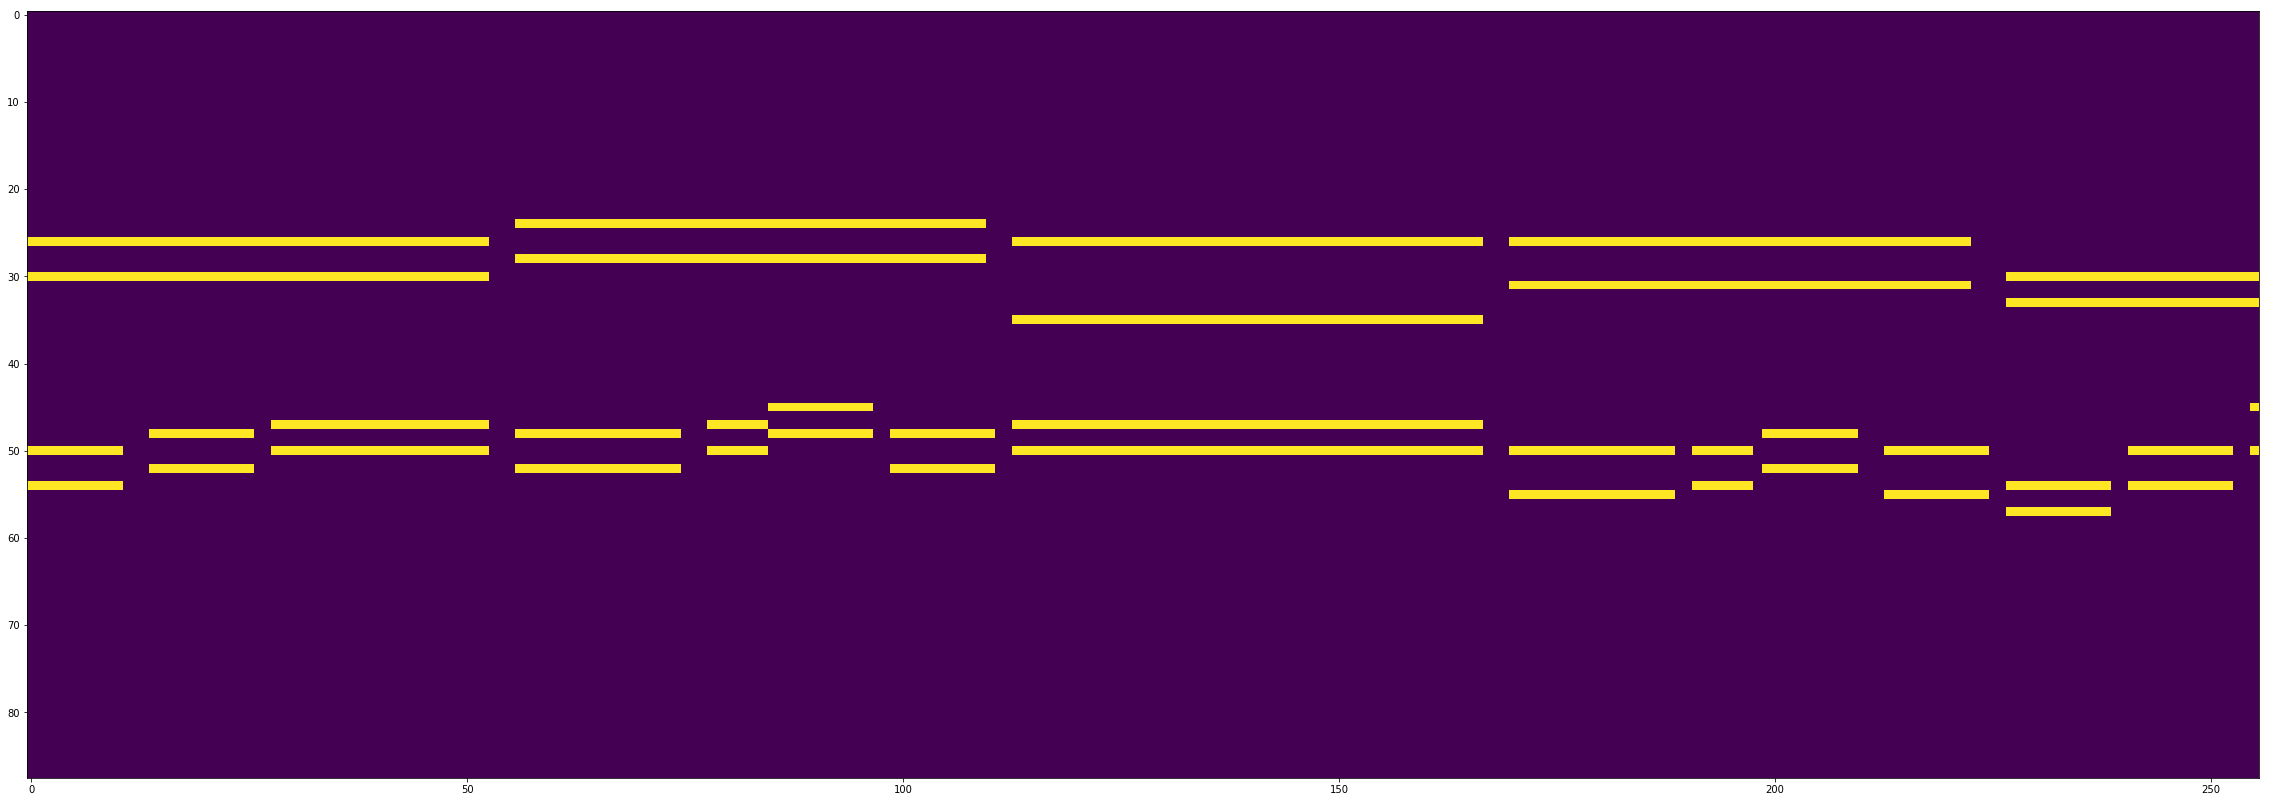

(88, 256)


In [ ]:
#show_pitch_occur(train_M)
test = None
while test is None:
    n = np.random.randint(len(train_M))
    print(n, train_M[n])
    test = read_midi(train_M[n], musicSize, fs, dur, pitch_range)
plt.figure(figsize = (40, 80))
plt.imshow(test)
plt.show()

pm = to_midi(test, fs, pitch_range, force_velocity= binary_music)
pm.write('test.mid')
print(test.shape)

In [ ]:
def minibatchS(data, batchsize, imgSize = spriteSize, augment = False):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_image(data[j], imgSize, augment) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.float32(rtn)       
        
def minibatchM(data, batchsize, imgSize = musicSize, augment = False):
    length = len(data)
    epoch = i = 0
    tmpsize = None    
    while True:
        size = tmpsize if tmpsize else batchsize
        if i+size > length:
            shuffle(data)
            i = 0
            epoch+=1        
        rtn = [read_midi(data[j], imgSize, fs, dur, pitch_range, augment) for j in range(i,i+size)]
        i+=size
        tmpsize = yield epoch, np.expand_dims(np.float32(rtn), -1)

def minibatchMS(dataM, dataS, batchsize):
    batchM=minibatchM(dataM, batchsize, augment=False)
    batchS=minibatchS(dataS, batchsize, augment=True)
    tmpsize = None
    while True:        
        ep1, M = batchM.send(tmpsize)
        ep2, S = batchS.send(tmpsize)
        tmpsize = yield max(ep1, ep2), M, S

In [ ]:
def showX(X, imageWidth, imageHeight, nc, rows=1, figsize = (20, 40)):
    assert X.shape[0]%rows == 0
    cols = X.shape[0]//rows
    plt.figure(figsize=figsize)
    for r in range(rows):
        for c in range(cols):
            i = r*cols + c
            int_X = X[i]
            if (imageHeight, imageWidth) == spriteSize:
                int_X = ((int_X+1)/2)
            int_X = (int_X*255).clip(0,255).astype('uint8')
            if channel_first:
                int_X = np.moveaxis(int_X.reshape(-1,nc,imageWidth, imageHeight), 1, nc)
            else:
                int_X = int_X.reshape(-1, imageWidth, imageHeight, nc)
            ax = plt.subplot(rows, cols, i+1)
            ax.imshow(np.squeeze(int_X), cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
            ax.axis('off')
    plt.show()

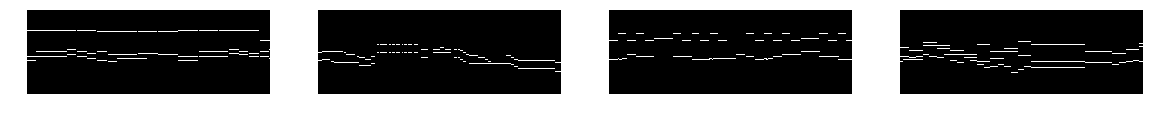

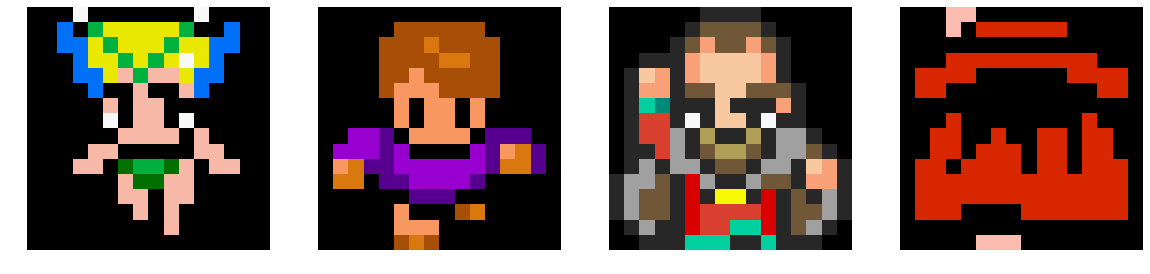

In [ ]:
train_batch = minibatchMS(train_M, train_S, 4)

_, M, S = next(train_batch)
showX(M, *musicSize, nc_m)
showX(S, *spriteSize, nc_s)
del train_batch, M, S

In [ ]:
def showG(M,S):
    def G(fn_generate, X):
        fakes = []
        recs = []
        for i in range(X.shape[0]):
            fake, rec = fn_generate([X[i:i+1]])
            fakes.append(fake[0])
            recs.append(rec[0])
        return [np.array(fakes), np.array(recs)]
    rM = G(cycleM_generate, M)
    rS = G(cycleS_generate, S)
    arr = [M,*rM,S,*rS]
    for elem in arr:
        print(elem.shape)
        showX(elem, elem.shape[1], elem.shape[2], elem.shape[3], 1)

[0/700][25] Loss_D: 65.589555 56.030891 Loss_G: 320.150204 23.775877 loss_cyc 0.862865 0.223
[0/700][50] Loss_D: 74.993875 43.971787 Loss_G: 68.440587 23.782726 loss_cyc 0.838561 0.300
[0/700][75] Loss_D: 31.438554 25.017719 Loss_G: 14.511911 18.779310 loss_cyc 0.838783 0.373
[0/700][100] Loss_D: 21.186820 21.223254 Loss_G: 11.130043 14.211756 loss_cyc 0.854142 0.444
[0/700][125] Loss_D: 12.933837 8.275126 Loss_G: 9.920930 8.089788 loss_cyc 0.824139 0.520
[0/700][150] Loss_D: 7.979198 5.896908 Loss_G: 3.741839 5.927166 loss_cyc 0.837684 0.595
[0/700][175] Loss_D: 9.389553 6.039813 Loss_G: 47.473775 5.772058 loss_cyc 0.803157 0.667
[0/700][200] Loss_D: 7.556265 4.432583 Loss_G: 17.651303 4.005929 loss_cyc 0.823392 0.751
[0/700][225] Loss_D: 5.171442 4.592065 Loss_G: 2.386484 3.157955 loss_cyc 0.802596 0.821
[0/700][250] Loss_D: 3.380363 3.112180 Loss_G: 9.267579 2.765278 loss_cyc 0.801819 0.891
[0/700][275] Loss_D: 2.485910 2.339198 Loss_G: 2.127592 2.083226 loss_cyc 0.786974 0.969
[0/7

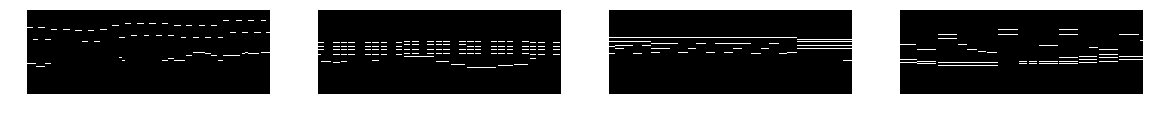

(4, 32, 32, 3)


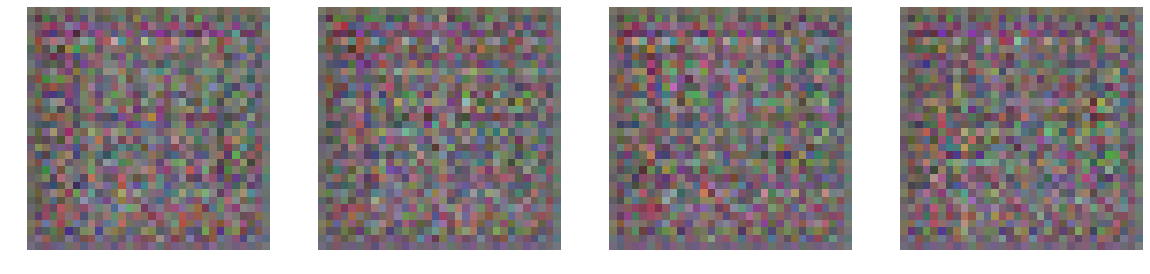

(4, 88, 256, 1)


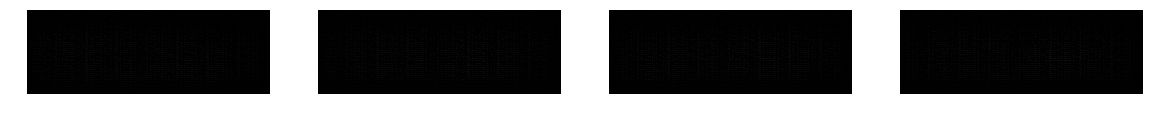

(4, 32, 32, 3)


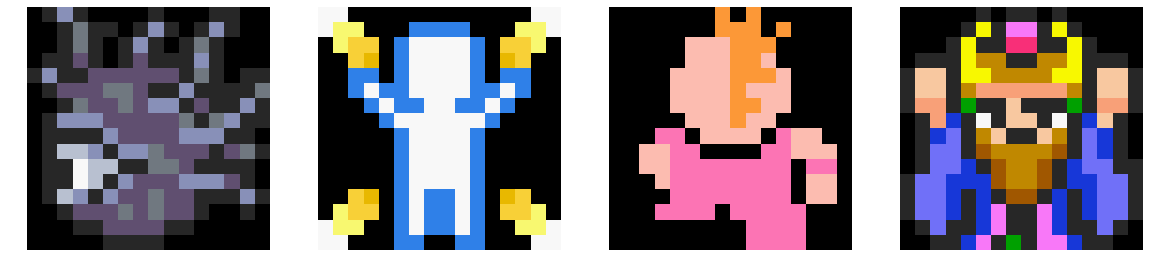

(4, 88, 256, 1)


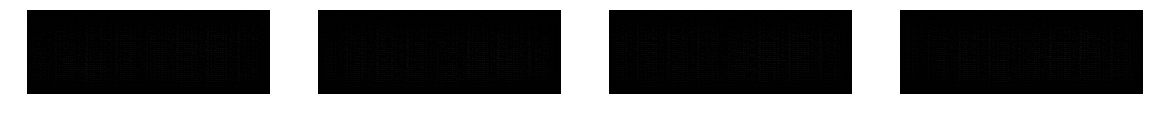

(4, 32, 32, 3)


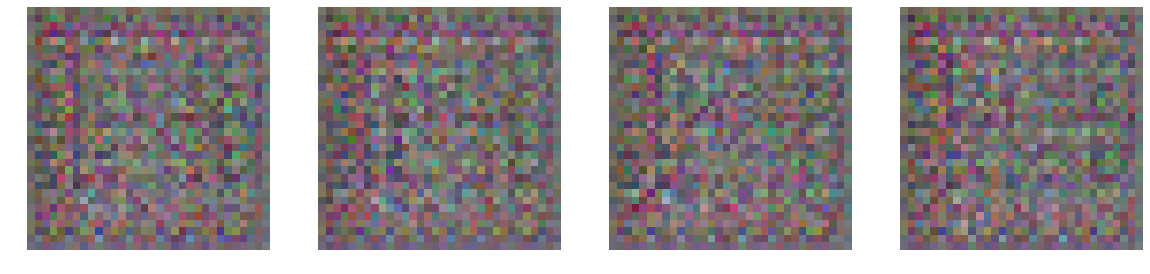

[1/700][375] Loss_D: 1.397452 1.562527 Loss_G: 2.318799 2.926008 loss_cyc 0.792308 1.323
[1/700][400] Loss_D: 2.019376 1.335772 Loss_G: 4.439119 1.867991 loss_cyc 0.810718 1.399
[1/700][425] Loss_D: 1.464250 1.069806 Loss_G: 3.186805 1.504873 loss_cyc 0.789269 1.467
[1/700][450] Loss_D: 1.072230 0.879269 Loss_G: 1.429980 0.999112 loss_cyc 0.778114 1.543
[1/700][475] Loss_D: 1.114889 0.949321 Loss_G: 1.610862 1.205525 loss_cyc 0.779119 1.619
[1/700][500] Loss_D: 0.788593 0.683633 Loss_G: 1.314087 1.199580 loss_cyc 0.769951 1.697
[1/700][525] Loss_D: 0.989488 0.510336 Loss_G: 1.280859 0.906664 loss_cyc 0.787878 1.777
[1/700][550] Loss_D: 1.668188 1.428669 Loss_G: 1.744486 1.486455 loss_cyc 0.785392 1.854
[1/700][575] Loss_D: 0.743017 0.631381 Loss_G: 1.139597 1.181567 loss_cyc 0.773212 1.925
[1/700][600] Loss_D: 0.844631 1.053987 Loss_G: 1.338854 1.365316 loss_cyc 0.788938 2.001
[1/700][625] Loss_D: 0.935960 1.024497 Loss_G: 1.404513 1.487688 loss_cyc 0.793693 2.075
[1/700][650] Loss_D: 

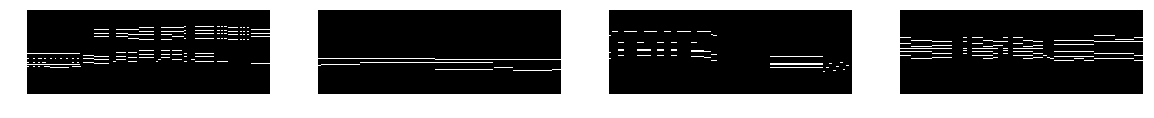

(4, 32, 32, 3)


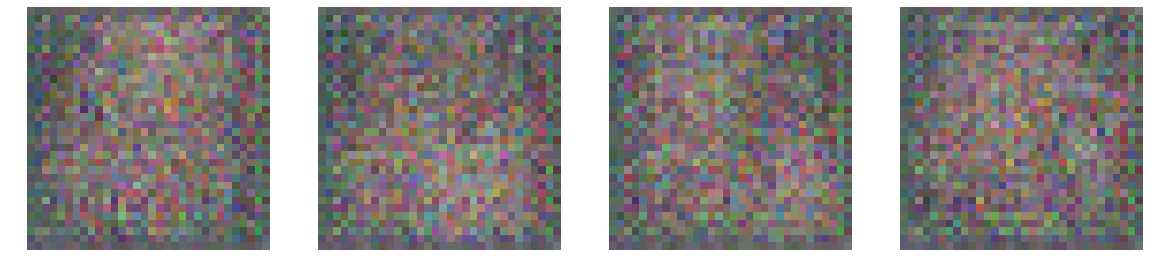

(4, 88, 256, 1)


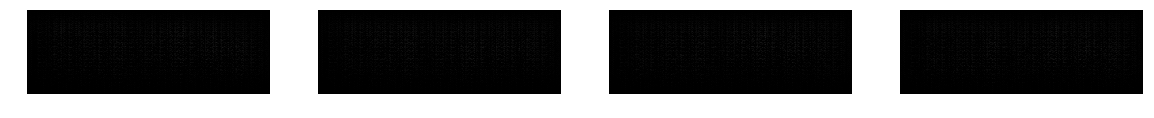

(4, 32, 32, 3)


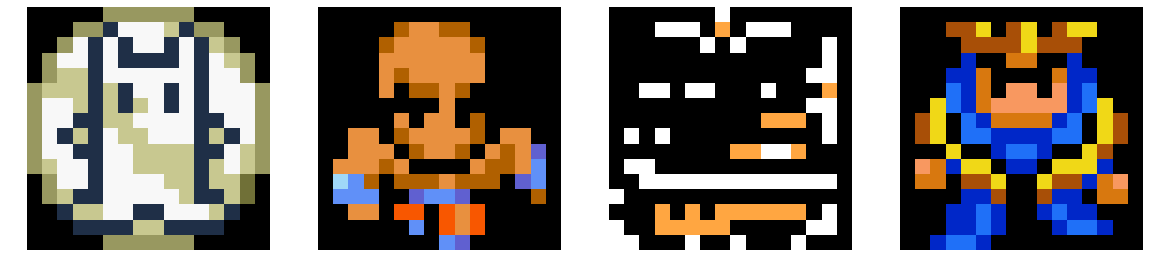

(4, 88, 256, 1)


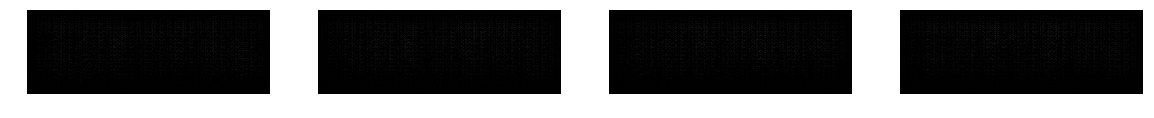

(4, 32, 32, 3)


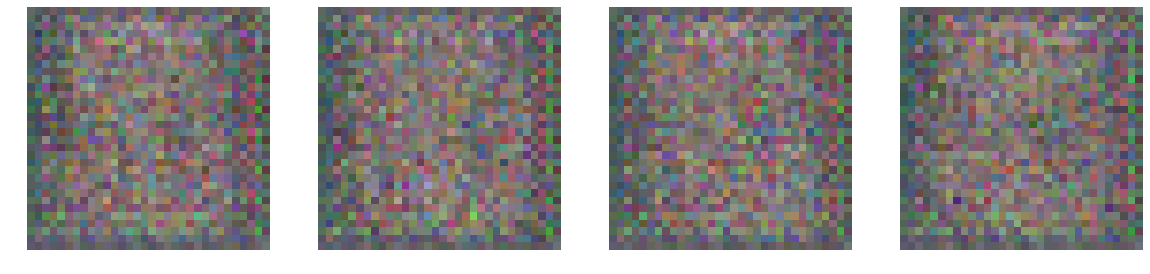

[2/700][700] Loss_D: 0.966145 1.447922 Loss_G: 1.246009 1.270021 loss_cyc 0.819047 2.322
[2/700][725] Loss_D: 0.744524 0.448877 Loss_G: 1.066062 1.012840 loss_cyc 0.773244 2.397
[2/700][750] Loss_D: 0.430353 0.507465 Loss_G: 1.155238 1.106126 loss_cyc 0.766099 2.475
[2/700][775] Loss_D: 0.483321 0.656440 Loss_G: 1.098537 1.245363 loss_cyc 0.763241 2.550
[2/700][800] Loss_D: 0.433629 0.401659 Loss_G: 1.425527 0.947397 loss_cyc 0.752981 2.629
[2/700][825] Loss_D: 0.746488 3.105041 Loss_G: 1.579730 2.018748 loss_cyc 0.760734 2.701
[2/700][850] Loss_D: 0.585415 2.444149 Loss_G: 1.521214 2.026510 loss_cyc 0.731648 2.771
[2/700][875] Loss_D: 0.529937 3.626134 Loss_G: 1.350922 1.545811 loss_cyc 0.751104 2.849
[2/700][900] Loss_D: 0.530711 0.725176 Loss_G: 1.442316 1.387881 loss_cyc 0.774204 2.929
[2/700][925] Loss_D: 0.483565 0.625246 Loss_G: 1.763173 0.981624 loss_cyc 0.758416 3.003
[2/700][950] Loss_D: 0.526102 0.567111 Loss_G: 1.403097 0.965195 loss_cyc 0.768808 3.077
[2/700][975] Loss_D: 

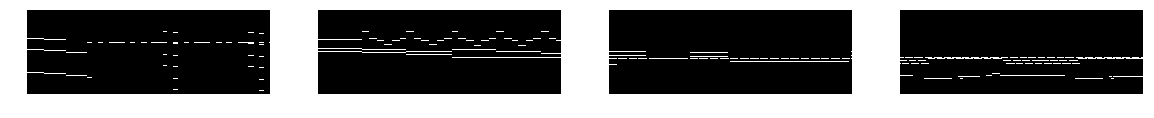

(4, 32, 32, 3)


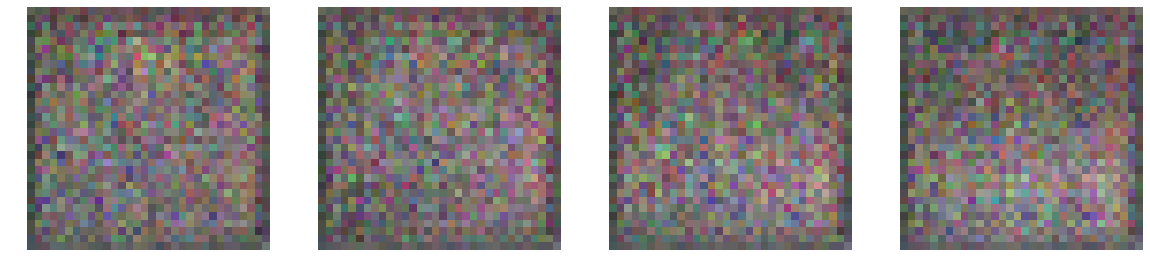

(4, 88, 256, 1)


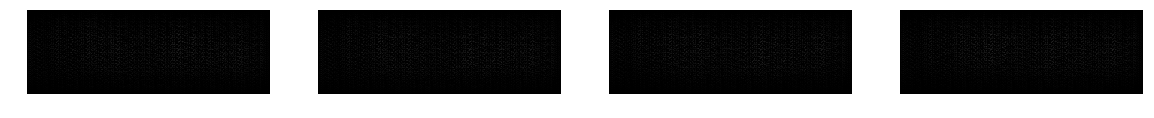

(4, 32, 32, 3)


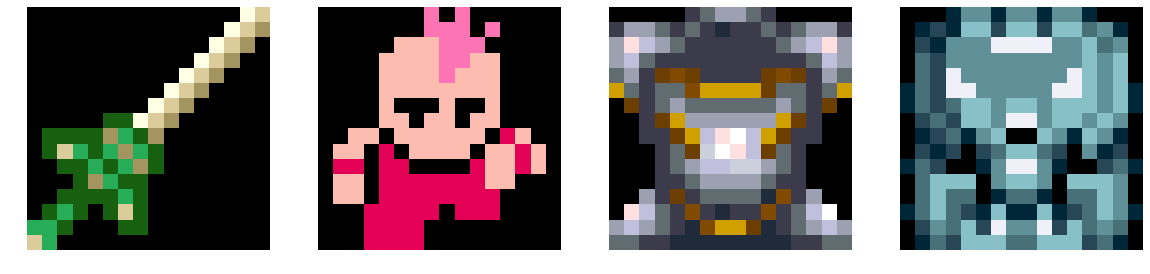

(4, 88, 256, 1)


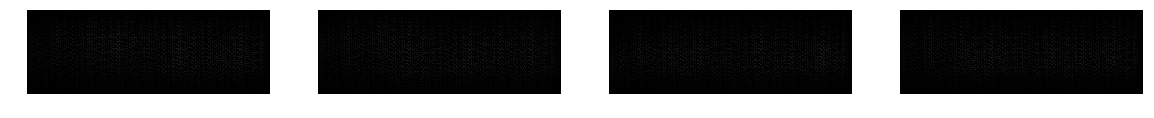

(4, 32, 32, 3)


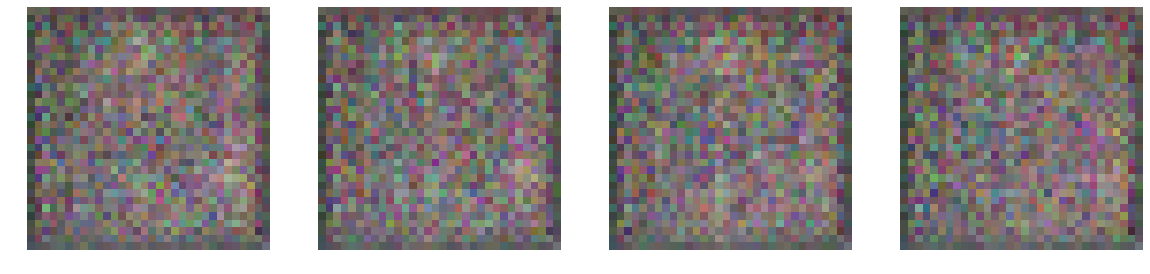

[3/700][1050] Loss_D: 0.422634 0.555966 Loss_G: 1.396738 1.291954 loss_cyc 0.762182 3.409
[3/700][1075] Loss_D: 0.425557 0.256360 Loss_G: 1.574381 0.979563 loss_cyc 0.769708 3.481
[3/700][1100] Loss_D: 0.278330 0.322370 Loss_G: 1.182599 0.848307 loss_cyc 0.742758 3.556
[3/700][1125] Loss_D: 0.316620 0.250219 Loss_G: 1.197470 0.883872 loss_cyc 0.749781 3.624
[3/700][1150] Loss_D: 0.283815 0.256697 Loss_G: 1.310514 1.054487 loss_cyc 0.768541 3.701
[3/700][1175] Loss_D: 0.214283 0.267280 Loss_G: 1.119152 0.856590 loss_cyc 0.770993 3.780
[3/700][1200] Loss_D: 0.356635 0.237544 Loss_G: 1.230443 0.938170 loss_cyc 0.767472 3.855
[3/700][1225] Loss_D: 0.343446 0.276078 Loss_G: 1.129230 0.893313 loss_cyc 0.766978 3.934
[3/700][1250] Loss_D: 0.251596 0.229544 Loss_G: 1.245442 0.849981 loss_cyc 0.759920 4.007
[3/700][1275] Loss_D: 0.529527 0.214292 Loss_G: 1.611784 1.005088 loss_cyc 0.766246 4.080
[3/700][1300] Loss_D: 0.349559 0.248322 Loss_G: 1.233419 0.772054 loss_cyc 0.767459 4.158
[3/700][13

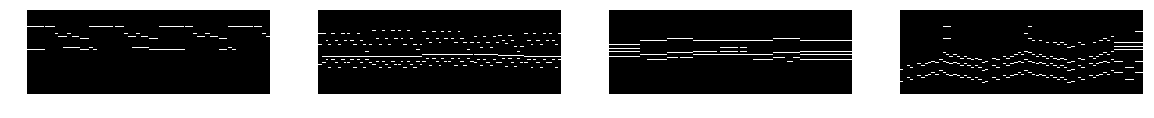

(4, 32, 32, 3)


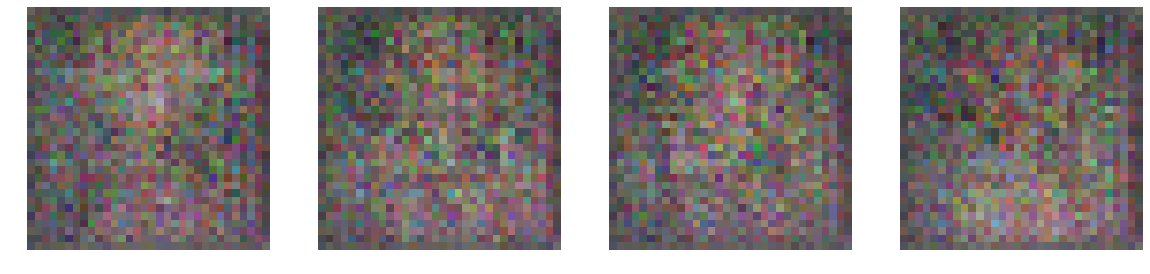

(4, 88, 256, 1)


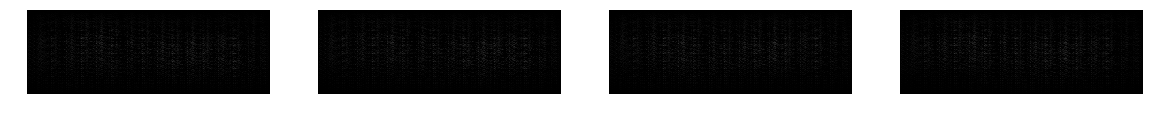

(4, 32, 32, 3)


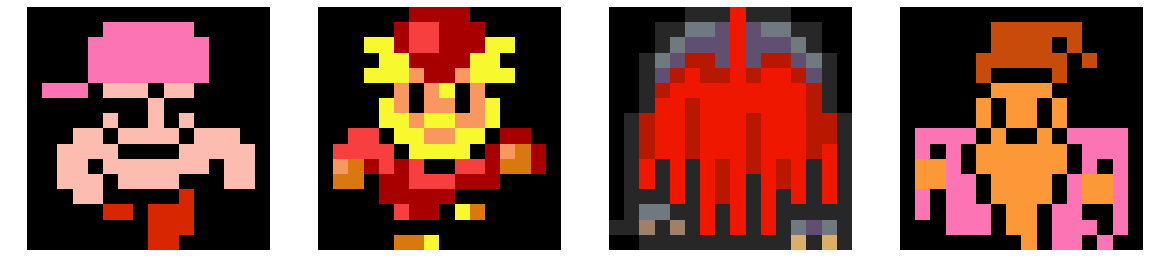

(4, 88, 256, 1)


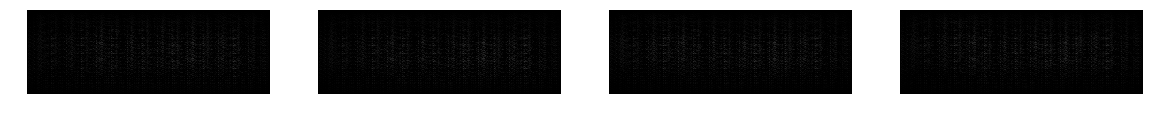

(4, 32, 32, 3)


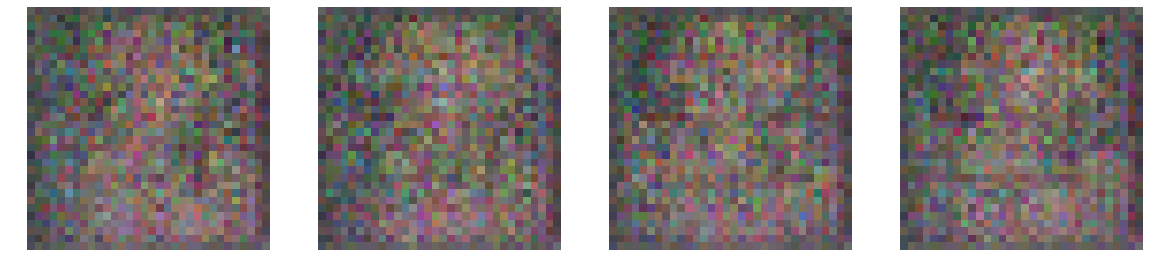

[4/700][1400] Loss_D: 0.332135 0.303059 Loss_G: 1.176893 0.983952 loss_cyc 0.761120 4.496
[4/700][1425] Loss_D: 0.194258 0.245890 Loss_G: 1.095171 1.054209 loss_cyc 0.757251 4.573
[4/700][1450] Loss_D: 0.361452 0.461379 Loss_G: 1.303505 1.023055 loss_cyc 0.766250 4.651
[4/700][1475] Loss_D: 0.534284 0.508804 Loss_G: 1.540812 1.083571 loss_cyc 0.744063 4.722
[4/700][1500] Loss_D: 0.305512 0.298257 Loss_G: 1.194742 0.914550 loss_cyc 0.742260 4.795
[4/700][1525] Loss_D: 0.242207 0.379239 Loss_G: 1.217104 1.091953 loss_cyc 0.740999 4.871
[4/700][1550] Loss_D: 0.290755 0.245613 Loss_G: 1.189959 0.941881 loss_cyc 0.742778 4.941
[4/700][1575] Loss_D: 0.276718 0.279867 Loss_G: 1.018817 0.928552 loss_cyc 0.750836 5.020
[4/700][1600] Loss_D: 0.211561 0.298698 Loss_G: 1.091152 0.971657 loss_cyc 0.730523 5.091
[4/700][1625] Loss_D: 0.182842 0.328350 Loss_G: 1.055291 0.966770 loss_cyc 0.769781 5.167
[4/700][1650] Loss_D: 0.283068 0.284728 Loss_G: 1.306022 1.045423 loss_cyc 0.726088 5.237
[4/700][16

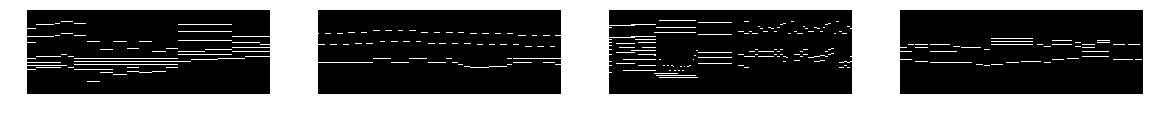

(4, 32, 32, 3)


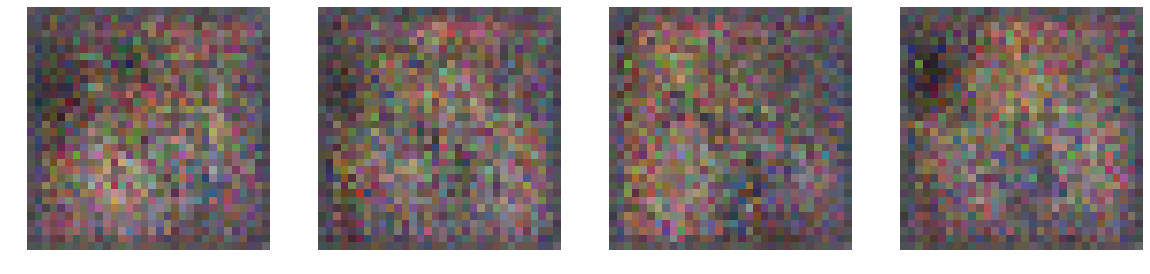

(4, 88, 256, 1)


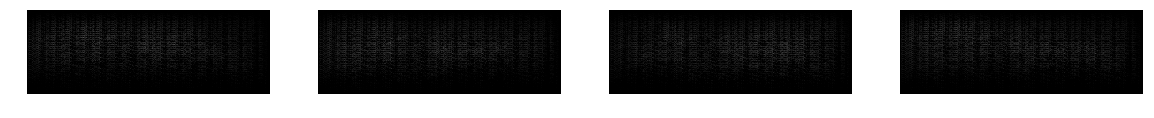

(4, 32, 32, 3)


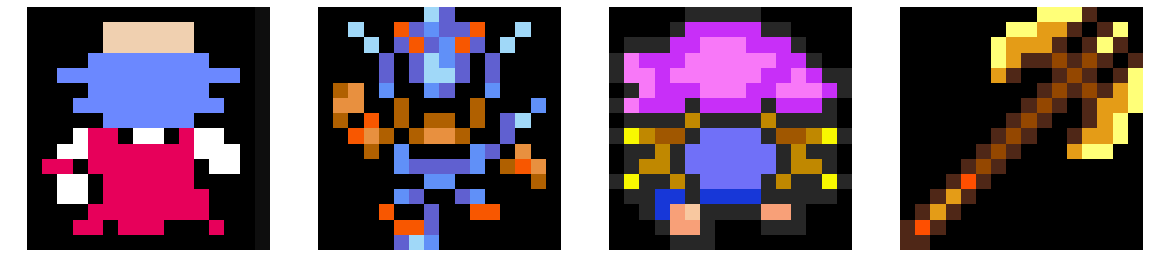

(4, 88, 256, 1)


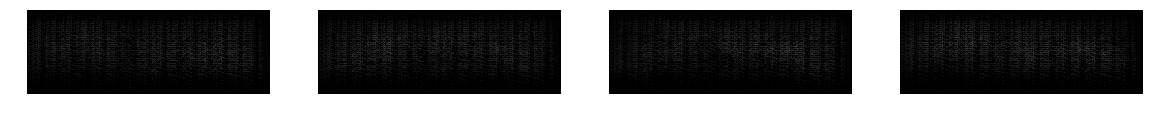

(4, 32, 32, 3)


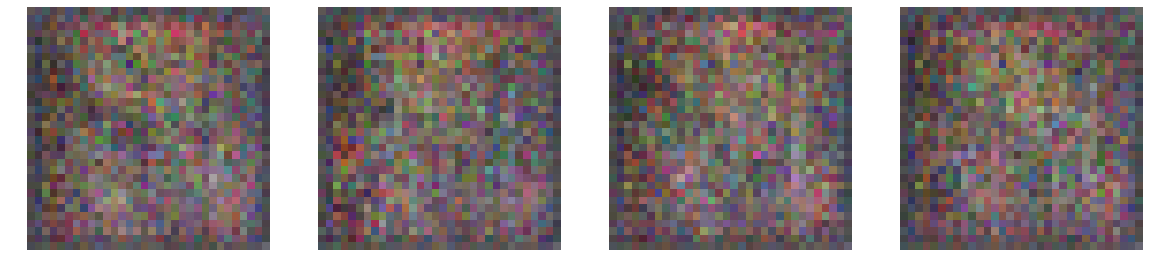

[5/700][1750] Loss_D: 0.282588 0.331329 Loss_G: 1.112463 1.018418 loss_cyc 0.739970 5.573
[5/700][1775] Loss_D: 0.437805 0.392267 Loss_G: 1.075543 1.076305 loss_cyc 0.743759 5.647
[5/700][1800] Loss_D: 0.336725 0.459710 Loss_G: 1.216275 1.307291 loss_cyc 0.754484 5.723
[5/700][1825] Loss_D: 0.218049 0.457753 Loss_G: 1.282364 0.996176 loss_cyc 0.741017 5.801
[5/700][1850] Loss_D: 0.177090 0.344122 Loss_G: 1.110293 1.067949 loss_cyc 0.738430 5.878
[5/700][1875] Loss_D: 0.631475 0.330503 Loss_G: 1.273087 0.976962 loss_cyc 0.738421 5.955
[5/700][1900] Loss_D: 0.328194 0.254683 Loss_G: 1.133426 1.013196 loss_cyc 0.733005 6.031
[5/700][1925] Loss_D: 0.338093 0.185085 Loss_G: 1.328040 0.879239 loss_cyc 0.731842 6.107
[5/700][1950] Loss_D: 0.164934 0.277976 Loss_G: 1.205654 0.948664 loss_cyc 0.736920 6.181
[5/700][1975] Loss_D: 0.197146 0.377077 Loss_G: 1.126160 0.931976 loss_cyc 0.719171 6.255
[5/700][2000] Loss_D: 0.321951 0.220127 Loss_G: 1.012310 0.954336 loss_cyc 0.728212 6.335
[5/700][20

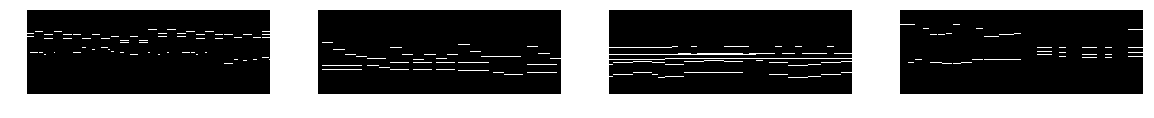

(4, 32, 32, 3)


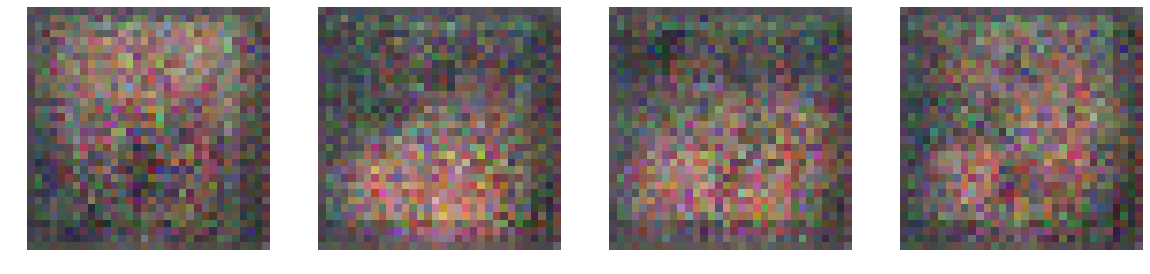

(4, 88, 256, 1)


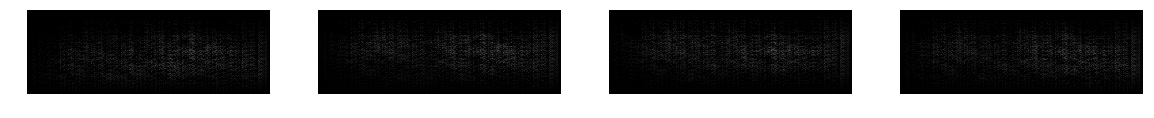

(4, 32, 32, 3)


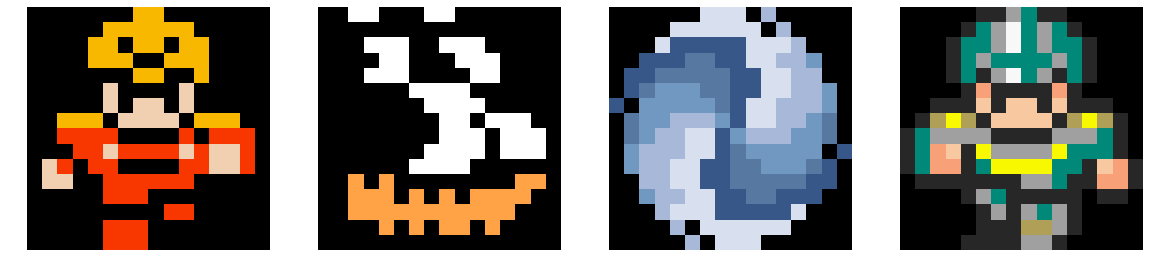

(4, 88, 256, 1)


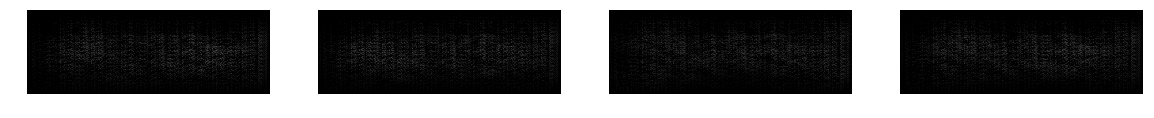

(4, 32, 32, 3)


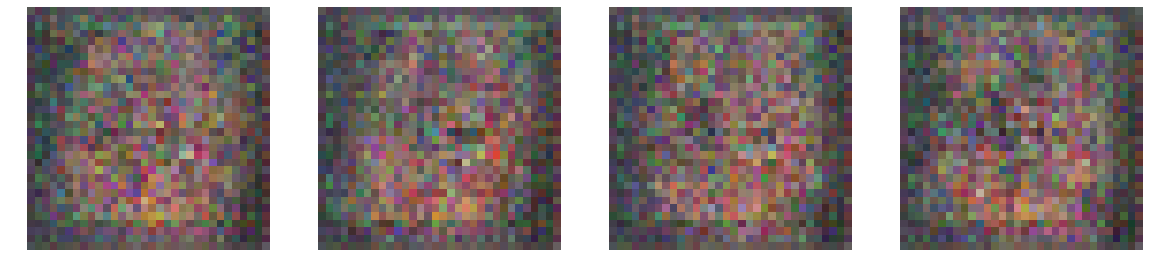

[6/700][2100] Loss_D: 0.239705 0.593068 Loss_G: 1.105334 1.174296 loss_cyc 0.708543 6.658
[6/700][2125] Loss_D: 0.177853 0.353007 Loss_G: 1.076663 1.102008 loss_cyc 0.736378 6.734
[6/700][2150] Loss_D: 0.133191 0.337929 Loss_G: 1.137489 1.113144 loss_cyc 0.734909 6.805
[6/700][2175] Loss_D: 0.411193 0.249433 Loss_G: 1.181062 0.845900 loss_cyc 0.722252 6.880
[6/700][2200] Loss_D: 0.196842 0.181617 Loss_G: 1.139902 0.972720 loss_cyc 0.704472 6.954
[6/700][2225] Loss_D: 0.228085 0.186085 Loss_G: 1.079022 0.914684 loss_cyc 0.725759 7.027
[6/700][2250] Loss_D: 0.179052 0.375814 Loss_G: 1.099460 0.962143 loss_cyc 0.726865 7.104


In [ ]:
import time
from IPython.display import clear_output
t0 = time.time()
niter = 700
gen_iterations = 0
epoch = 0
errCyc_sum = errGM_sum = errGS_sum = errDM_sum = errDS_sum = 0

past_epoch = 0
display_iters = 25
#val_batch = minibatch(valAB, 6, direction)
train_batch = minibatchMS(train_M, train_S, batchSize)

while epoch < niter: 
    epoch, M, S = next(train_batch)  
    errDM, errDS  = netD_train([M, S])
    errDM_sum +=errDM
    errDS_sum +=errDS

    # epoch, trainA, trainB = next(train_batch)
    errGM, errGS, errCyc = netG_train([M, S])
    errGM_sum += errGM
    errGS_sum += errGS
    errCyc_sum += errCyc
    gen_iterations+=1
    if gen_iterations%display_iters==0:
        #if gen_iterations%(5*display_iters)==0:
        #clear_output()
        print('[%d/%d][%d] Loss_D: %f %f Loss_G: %f %f loss_cyc %f'
        % (epoch, niter, gen_iterations, errDM_sum/display_iters, errDS_sum/display_iters,
           errGM_sum/display_iters, errGS_sum/display_iters, 
           errCyc_sum/display_iters), "%.3f" % ((time.time()-t0)/60.0))
        errCyc_sum = errGM_sum = errGS_sum = errDM_sum = errDS_sum = 0
    if epoch != past_epoch:
        _, M, S = train_batch.send(4)
        showG(M,S)
        past_epoch = epoch

In [ ]:
# save all the things
netDM.save('run03_netDM')
netDS.save('run03_netDS')
netGM.save('run03_netGM')
netGS.save('run03_netGS')